In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import pandas as pd
import pickle
from sklearn.metrics import classification_report, f1_score

In [ ]:
zip_path = '/content/Brain MRI.zip'
extract_path = '/content/brain_mri_dataset'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Dataset extracted successfully!")

Dataset extracted successfully!


In [ ]:
data_dir = os.path.join(extract_path, "/content/brain_mri_dataset/Training")  # Adjust if "Training" is not the correct subfolder
test_dir = os.path.join(extract_path, "/content/brain_mri_dataset/Testing")
img_height = 224
img_width = 224
batch_size = 32

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [ ]:
#Define ResNet Module

base_model = ResNet50(weights='imagenet', include_top=False, input_shape = (img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_data.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

print("Training TensorFlow (Keras) model...")
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=[early_stopping, reduce_lr]
)

val_loss, val_accuracy = model.evaluate(val_data)
print(f"TensorFlow Model Validation Accuracy: {val_accuracy:.4f}, Loss: {val_loss:.4f}")

# Save the TensorFlow model
model.save('/content/brain_mri_model.h5')
print("TensorFlow model training complete and saved as 'brain_mri_model.h5'.")

test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_data)
print(f"TensorFlow Model Test Accuracy: {test_accuracy:.4f}, Loss: {test_loss:.4f}")

Training TensorFlow (Keras) model...
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 1190s 8s/step - accuracy: 0.3580 - loss: 1.4405 - val_accuracy: 0.4575 - val_loss: 1.2156 - learning_rate: 0.0010
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 1162s 8s/step - accuracy: 0.4528 - loss: 1.1144 - val_accuracy: 0.4750 - val_loss: 1.2079 - learning_rate: 0.0010
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 1155s 8s/step - accuracy: 0.4827 - loss: 1.0796 - val_accuracy: 0.4961 - val_loss: 1.2323 - learning_rate: 0.0010
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 1166s 8s/step - accuracy: 0.4845 - loss: 1.0587 - val_accuracy: 0.4671 - val_loss: 1.2027 - learning_rate: 0.0010
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 1157s 8s/step - accuracy: 0.5034 - loss: 1.0556 - val_accuracy: 0.4452 - val_loss: 1.1987 - learning_rate: 0.0010
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 1200s 8s/step - accuracy: 0.5048 - loss: 1.0550 - val_accuracy: 0.4557 - val_loss: 1.2344 - learning_rate: 0.0010
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 1154s 8s/step - accuracy: 0.5061 - loss: 1.0558

In [ ]:
tf_model_path = "/content/brain_mri_model.h5"
tf_model = load_model(tf_model_path)

test_dir = '/content/brain_mri_dataset/Testing'

# Parameters
img_height = 224
img_width = 224
batch_size = 32

# Prepare the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep the order consistent for evaluation
)

# Run predictions on the test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Map predicted class indices to tumor types
class_indices = test_generator.class_indices  # {'glioma': 0, 'meningioma': 1, ...}
index_to_class = {v: k for k, v in class_indices.items()}  # Reverse the mapping

# Generate results
results = []
filenames = test_generator.filenames

for i, filename in enumerate(filenames):
    predicted_label = index_to_class[predicted_classes[i]]
    results.append((filename, predicted_label))

# Print and save the results
print("\n--- Prediction Results ---")
for filename, label in results:
    print(f"Image: {filename}, Predicted Tumor Type: {label}")

# Optionally save results to a CSV file
results_df = pd.DataFrame(results, columns=['Image', 'Predicted Tumor Type'])
results_df.to_csv('prediction_results.csv', index=False)
print("\nResults saved to 'prediction_results.csv'")

Found 1311 images belonging to 4 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 228s 6s/step

--- Prediction Results ---
Image: glioma/Te-glTr_0000.jpg, Predicted Tumor Type: notumor
Image: glioma/Te-glTr_0001.jpg, Predicted Tumor Type: pituitary
Image: glioma/Te-glTr_0002.jpg, Predicted Tumor Type: glioma
Image: glioma/Te-glTr_0003.jpg, Predicted Tumor Type: notumor
Image: glioma/Te-glTr_0004.jpg, Predicted Tumor Type: glioma
Image: glioma/Te-glTr_0005.jpg, Predicted Tumor Type: pituitary
Image: glioma/Te-glTr_0006.jpg, Predicted Tumor Type: pituitary
Image: glioma/Te-glTr_0007.jpg, Predicted Tumor Type: pituitary
Image: glioma/Te-glTr_0008.jpg, Predicted Tumor Type: pituitary
Image: glioma/Te-glTr_0009.jpg, Predicted Tumor Type: pituitary
Image: glioma/Te-gl_0010.jpg, Predicted Tumor Type: pituitary
Image: glioma/Te-gl_0011.jpg, Predicted Tumor Type: notumor
Image: glioma/Te-gl_0012.jpg, Predicted Tumor Type: glioma
Image: glioma/Te-gl_0013.jpg, Predicted Tumor Type: notumor
Image: glioma/Te-gl

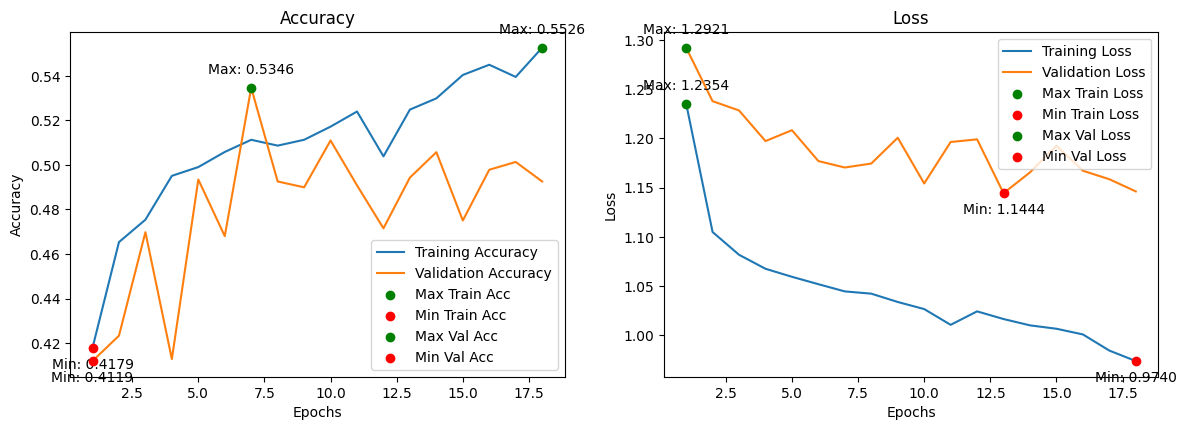

In [15]:
import matplotlib.pyplot as plt

def plot_training_history_with_extremes(history):
    # Extract data
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    lr = history.history.get('lr', [])

    epochs = range(1, len(acc) + 1)

    def mark_extremes(ax, data, label):
        if not data:
            return
        max_index = data.index(max(data))
        min_index = data.index(min(data))
        ax.scatter(max_index + 1, max(data), color='green', label=f'Max {label}', zorder=5)
        ax.scatter(min_index + 1, min(data), color='red', label=f'Min {label}', zorder=5)
        ax.annotate(f'Max: {max(data):.4f}', (max_index + 1, max(data)), textcoords="offset points", xytext=(0, 10), ha='center')
        ax.annotate(f'Min: {min(data):.4f}', (min_index + 1, min(data)), textcoords="offset points", xytext=(0, -15), ha='center')

    # Plot Accuracy
    plt.figure(figsize=(12, 8))
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(epochs, acc, label='Training Accuracy')
    ax1.plot(epochs, val_acc, label='Validation Accuracy')
    mark_extremes(ax1, acc, 'Train Acc')
    mark_extremes(ax1, val_acc, 'Val Acc')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot Loss
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(epochs, loss, label='Training Loss')
    ax2.plot(epochs, val_loss, label='Validation Loss')
    mark_extremes(ax2, loss, 'Train Loss')
    mark_extremes(ax2, val_loss, 'Val Loss')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Plot Learning Rate
    if lr:
        ax3 = plt.subplot(2, 2, 3)
        ax3.plot(epochs, lr, label='Learning Rate', color='purple')
        mark_extremes(ax3, lr, 'Learning Rate')
        ax3.set_title('Learning Rate')
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Learning Rate')
        ax3.legend()

    plt.tight_layout()
    plt.show()

# Usage: Assuming history is the object returned by model.fit()
plot_training_history_with_extremes(history)


In [ ]:
# Paths
tf_model_path = '/content/brain_mri_model.h5'  # Replace with the path to your model
test_dir = '/content/brain_mri_dataset/Testing'      # Replace with the path to your testing dataset

# Load the model
model = load_model(tf_model_path)
print("Model loaded successfully!")

# Parameters
img_height = 224
img_width = 224
batch_size = 32

# Prepare the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get true labels and predictions
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate F1-Score
f1 = f1_score(true_labels, predicted_classes, average='weighted')  # Use 'weighted' for imbalanced datasets
print(f"Weighted F1-Score: {f1:.4f}")

# Detailed Classification Report
class_indices = test_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}  # Reverse the class_indices
report = classification_report(true_labels, predicted_classes, target_names=class_labels.values())
print("\nClassification Report:\n")
print(report)

with open('classification_report.txt', 'w') as f:
    f.write(report)
print("Classification report saved to 'classification_report.txt'")


Model loaded successfully!
Found 1311 images belonging to 4 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 226s 5s/step
Weighted F1-Score: 0.4705

Classification Report:

              precision    recall  f1-score   support

      glioma       0.56      0.15      0.24       300
  meningioma       0.49      0.31      0.38       306
     notumor       0.63      0.82      0.71       405
   pituitary       0.38      0.63      0.47       300

    accuracy                           0.51      1311
   macro avg       0.51      0.48      0.45      1311
weighted avg       0.52      0.51      0.47      1311

Classification report saved to 'classification_report.txt'


In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

def preprocess_image(image_path, target_size):
    """Load and preprocess an image for the model."""
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    return tf.keras.applications.resnet.preprocess_input(image_array)

def get_last_conv_layer(model):
    """Retrieve the last convolutional layer of the model."""
    for layer in reversed(model.layers):
        if 'conv' in layer.name:
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

def generate_gradcam(model, image_array, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap."""
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute pooled gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply gradients by activations and average
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(heatmap, image_path, alpha=0.4):
    """Overlay the Grad-CAM heatmap on the original image."""
    img = cv2.imread(image_path)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_colored, alpha, img, 1 - alpha, 0)
    return superimposed_img

def analyze_with_gradcam(model, test_folder, target_size):
    """Apply Grad-CAM on all images in the testing folder."""
    last_conv_layer_name = get_last_conv_layer(model)

    for image_file in os.listdir(test_folder):
        image_path = os.path.join(test_folder, image_file)
        if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        # Preprocess image
        image_array = preprocess_image(image_path, target_size)

        # Generate Grad-CAM heatmap
        heatmap = generate_gradcam(model, image_array, last_conv_layer_name)

        # Overlay heatmap on the original image
        superimposed_image = overlay_heatmap(heatmap, image_path)

        # Display the results
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(superimposed_image, cv2.COLOR_BGR2RGB))
        plt.title("Grad-CAM")
        plt.axis("off")
        plt.show()

# Load your ResNet model (adjust path as necessary)
model = tf.keras.models.load_model('/content/brain_mri_model.h5')

# Specify the testing folder and target input size for the model
test_folder = '/content/brain_mri_dataset/Testing/glioma/Te-glTr_0003.jpg'
target_size = (224, 224)  # Adjust based on your model's input size

# Analyze test images with Grad-CAM
analyze_with_gradcam(model, test_folder, target_size)


NotADirectoryError: [Errno 20] Not a directory: '/content/brain_mri_dataset/Testing/glioma/Te-glTr_0003.jpg'